#**Import necessary libraries for data processing, modeling, and evaluation**

In [30]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#**Load the blood donor dataset and display the first few rows**

In [4]:
df = pd.read_csv("/content/blood_donor_dataset.csv")
df.head()

,donor_id,name,email,password,contact_number,city,blood_group,availability,months_since_first_donation,number_of_donation,pints_donated,created_at
0,1b8b4c828a,Norma Fisher,ysullivan@yahoo.com,P5hX6Syg*A,+61 461706749,Hobart,A+,No,65,31,62,2017-03-17
1,a6a3f7fe55,Eugene Bowman,hramos@brown-sellers.com,b6Wq6Cqz@5,+61 450709944,Darwin,AB-,Yes,64,8,16,2016-11-11
2,cee6478144,Sheri Bolton DDS,jasmine85@hotmail.com,$9RB51m#s7,+61 428756361,Melbourne,AB+,Yes,39,6,6,2022-02-25
3,5986bc55f9,Kelly Boyd,pattylawrence@riley-hayes.com,@5Tdg(4kCm,+61 454318320,Darwin,A-,No,55,20,20,2025-04-04
4,93246afe6c,Taylor Guzman,martinezjacob@wilson.com,x!)9Ag@J*7,+61 484158472,Darwin,O-,No,7,35,35,2022-11-30


#**Drop unnecessary columns and display the updated dataframe head**

In [10]:
df = df.drop(columns=['donor_id', 'name', 'email', 'password', 'contact_number', 'city', 'created_at' ])

In [11]:
df.head()

,blood_group,availability,months_since_first_donation,number_of_donation,pints_donated
0,A+,No,65,31,62
1,AB-,Yes,64,8,16
2,AB+,Yes,39,6,6
3,A-,No,55,20,20
4,O-,No,7,35,35


#**Define features and target variable for the model and Prepare features (X) and target (y), encode labels, scale features, and split data**

In [13]:
features = ['months_since_first_donation', 'number_of_donation', 'pints_donated', 'blood_group']
target = 'availability'  # Binary: Yes/No

#X,Y
X = df[features]
y = df[target]

# Encode target (Yes=1, No=0)
le = LabelEncoder()
y = le.fit_transform(y)

# Encode blood_group
le_blood = LabelEncoder()
X['blood_group'] = le_blood.fit_transform(X['blood_group'])

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipython-input-4225836864.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['blood_group'] = le_blood.fit_transform(X['blood_group'])


#**Print the mapping of blood groups to their encoded values**

In [14]:
blood_group_mapping = dict(zip(le_blood.classes_, range(len(le_blood.classes_))))
for blood_group, code in blood_group_mapping.items():
    print(f"Blood Group: {blood_group}, Encoded as: {code}")

Blood Group: A+, Encoded as: 0
Blood Group: A-, Encoded as: 1
Blood Group: AB+, Encoded as: 2
Blood Group: AB-, Encoded as: 3
Blood Group: B+, Encoded as: 4
Blood Group: B-, Encoded as: 5
Blood Group: O+, Encoded as: 6
Blood Group: O-, Encoded as: 7


#**Build, compile, and train the initial deep learning model with callbacks**

In [32]:
# Build a more robust deep learning model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
          callbacks=[early_stopping, reduce_lr], verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4905 - loss: 0.7599 - val_accuracy: 0.4881 - val_loss: 0.6968 - learning_rate: 5.0000e-04
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4959 - loss: 0.7239 - val_accuracy: 0.4906 - val_loss: 0.6988 - learning_rate: 5.0000e-04
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4875 - loss: 0.7170 - val_accuracy: 0.4875 - val_loss: 0.7023 - learning_rate: 5.0000e-04
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4923 - loss: 0.7112 - val_accuracy: 0.4875 - val_loss: 0.7008 - learning_rate: 5.0000e-04
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5126 - loss: 0.7009 - val_accuracy: 0.4806 - val_loss: 0.7053 - learning_rate: 5.0000e-04
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5197 - loss: 0.6991 - val_accuracy: 0.4913 - val_loss: 0.7018 - learning_rate: 5.0000e-04
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

#**Evaluate the model on the test set and print accuracy**

In [33]:
# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5032 - loss: 0.6968
Test Accuracy: 50.05%


#**Generate predictions on the test set and convert to binary output**

In [34]:
# Step 8: Make predictions (example on test data)
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Binary output

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


#**Display a comparison dataframe of actual vs predicted values**

In [35]:
# Display predictions vs actual values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.flatten()  # Flatten to match shapes
})
print("\nPredictions vs Actual Values:")
print(comparison_df.head(20))  # Display first 20 for brevity; adjust as needed


Predictions vs Actual Values:
    Actual  Predicted
0        0          0
1        1          1
2        0          0
3        0          0
4        0          0
5        0          0
6        1          1
7        0          1
8        0          1
9        1          0
10       0          1
11       1          0
12       0          1
13       1          0
14       0          0
15       1          0
16       0          1
17       1          0
18       0          0
19       0          1


#**Compute and plot the ROC curve with AUC value**

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


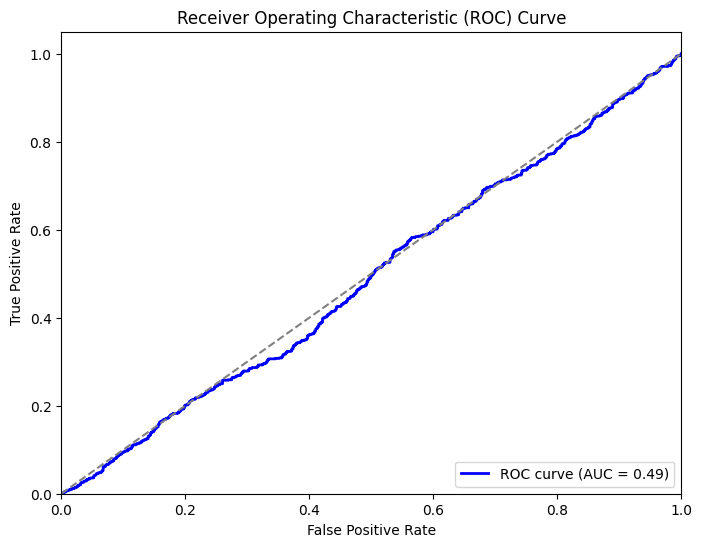

In [36]:
# Get predicted probabilities
probs = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**powerd by Miracle⚡**